## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

from scipy.special import expit
from scipy import optimize

%matplotlib inline

## Organizing the Data

In [3]:
# Determining whether microchips from a fabrication plant passes quality assurance based on two tests

datafile = "ex2data2.txt"
cols = np.loadtxt(datafile, delimiter=",", usecols=(0,1,2), unpack=True)

# for lists the order is [columns, rows]
# for numpy array the order is [rows, columns]
# numpy count starts at 0

X = np.transpose(np.array(cols[0:2,:]))
y = np.transpose(np.array(cols[2:,:]))
m = y.size


#np.insert(object, column which to insert, variable to insert, axis=1,0 to insert each row, column)
##Insert the usual column of 1's into the "X" matrix because theta0 is by itself, not multiplied to anything
X = np.insert(X,0,1,axis=1)

## Visualizing the Data

In [4]:
# Seperating data into passed vs failed pool
passed = np.array([X[i] for i in range(X.shape[0]) if y[i] == 1])
rejected = np.array([X[i] for i in range(X.shape[0]) if y[i] == 0])

# shape[0] = all rows | shape[1] = all columns

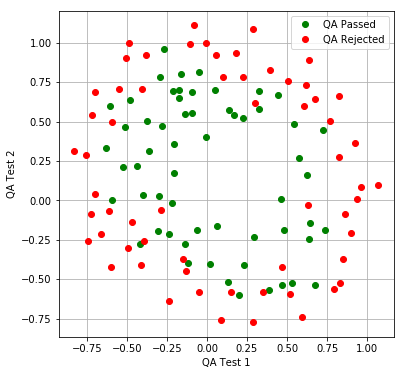

In [5]:
def plot_data():
    plt.plot(passed[:,1],passed[:,2],'go',label='QA Passed')
    plt.plot(rejected[:,1],rejected[:,2],'ro',label='QA Rejected')
    plt.xlabel('QA Test 1')
    plt.ylabel('QA Test 2')
    plt.legend()
    plt.grid(True)

plt.figure(figsize=(6,6))
plot_data()

## Feature Mapping

In [6]:
# Code provided in homework
# As a result of this mapping, the initial vector of two features (the scores on two QA tests) 
# has been transformed into a 28-dimensional vector.
# A logistic regression classifier trained on this higher-dimension feature vector will have
# a more complex decision boundary and will appear nonlinear when drawn in the 2-dimensional plot.
# While feature mapping allows us to build a more expressive classifier, it also more susceptible to overfitting.

def mapFeature( x1col, x2col ):
    """ 
    Function that takes in a column of n- x1's, a column of n- x2s, and builds
    a n- x 28-dim matrix of featuers as described in the homework assignment
    """
    degrees = 6
    out = np.ones( (x1col.shape[0], 1) )

    for i in range(1, degrees+1):
        for j in range(0, i+1):
            term1 = x1col ** (i-j)
            term2 = x2col ** (j)
            term  = (term1 * term2).reshape( term1.shape[0], 1 ) 
            out   = np.hstack(( out, term ))
    return out

# np.hstack --> https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.hstack.html

In [7]:
#Create feature-mapped X matrix
mappedX = mapFeature(X[:,1],X[:,2]) #mappedX.shape = (118, 28)

# X[:,1].shape = (118,)
# X[:,2].shape = (118,)

## Implementing Regularized Logistic Regression

In [8]:
# for lists the order is [columns, rows]
# for numpy array the order is [rows, columns]
# numpy count starts at 0
# shape[0] = # of rows | shape[1] = # of columns 

initial_theta = np.zeros((mappedX.shape[1],1))

In [131]:
def hypothesis(theta,X):
    return expit(np.dot(X,theta))

# X.shape = (118,3)
# mappedX.shape = (118, 28)
# initial_theta.shape = (28,1)

In [132]:
# Cost function
def cost_function(theta, X, y, my_lambda=0.):
    term1 = np.dot(np.array(y).T, np.log(hypothesis(theta,X)))
    term2 = np.dot(1-np.array(y).T,np.log(1-hypothesis(theta,X)))
    regterm = (my_lambda/(2*m)) * np.sum(np.dot(theta[1:].T,theta[1:])) #Skip theta0
    return float (-(1/m)* (np.sum(term1 + term2))) + regterm

# np.array(y).shape = (118,1)
# hypothesis(initial_theta,X).shape = (118,1)
# np.log(1-hypothesis(theta,X)).shape = (118,1)
# initial_theta[1:].shape = (27,1)
# term1.shape = (1,1)
# term2.shape = (1,1)
# np.sum(term1 + term2) = ()
# cost_function returns a float in the end

In [133]:
# Testing the cost function before optimizing theta
cost_function(initial_theta, mappedX, y)

0.6931471805599454

In [134]:
# Optimize theta
# Optimize.fmin passed max iterations. Using optimize.minimize instead
# Difference between the two: https://stackoverflow.com/questions/49094774/difference-between-scipy-optimize-fmin-and-scipy-optimize-minimize
# BFGS is the Broyden–Fletcher–Goldfarb–Shanno algorithm: https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm

def optimize_regtheta(theta, X, y, my_lambda=0.):
    result = optimize.minimize(cost_function, theta, args=(X, y, my_lambda),  method='BFGS', options={"maxiter":500, "disp":False} )
    return np.array([result.x]), result.fun

theta, mincost = optimize_regtheta(initial_theta,mappedX,y)

In [135]:
# Seeing the theta and cost function after optimizing for theta
theta, mincost

(array([[   19.69702031,    32.18176117,    16.04516476,  -192.3247898 ,
           -84.38526442,  -100.00904725,  -236.35612175,  -195.62441116,
          -127.84608844,   -40.08038764,   660.64285059,   503.83644163,
           818.08946787,   336.48856401,   181.77422862,   402.70461013,
           522.48900326,   620.66201846,   359.80453463,   129.30764971,
            35.00472741,  -773.39249905,  -902.27866082, -1512.30523101,
         -1042.11826649, -1020.56917306,  -380.67203682,  -123.20480888]]),
 0.2486561119500825)

## Plotting Decision Boundary

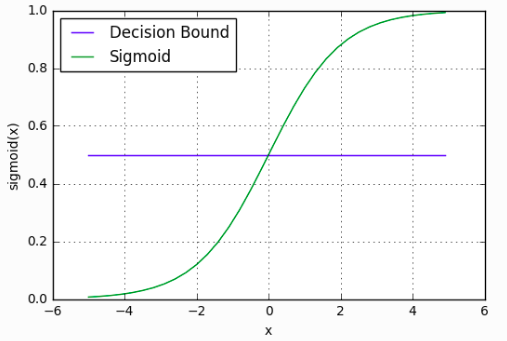

In [136]:
Image("Decision_boundary1.png", width=300, height=500)
# Decision boundary occurs when h = 0, or when
# theta0 + theta1*x1 + theta2*x2 = 0

In [137]:
def plot_boundary(theta, X, y, my_lambda=0.):
    
    theta, mincost = optimize_regtheta(theta, X, y, my_lambda)
    xvals = np.linspace(-1,1.5,50)
    yvals = np.linspace(-1,1.5,50)
    zvals = np.zeros((len(xvals),len(yvals)))
    for i in range(len(xvals)):
        for j in range(len(yvals)):
            featuresij = mapFeature(np.array([xvals[i]]),np.array([yvals[j]]))
            zvals[i][j] = np.dot(theta,featuresij.T)
    zvals = zvals.T
 
    u, v = np.meshgrid(xvals, yvals)
    mycontour = plt.contour(xvals, yvals, zvals, 0)

    myfmt = { 0:'Lambda = %d'%my_lambda}
    plt.clabel(mycontour, inline=1, fontsize=15, fmt=myfmt)
    plt.title("Decision Boundary")

# xvals shape = (50,)
# zvals.shape = (50,50)
# featuresij.shape = (1,28)
# theta.shape = (1,28)
# zvals[i][j].shape = ()
# What is np.meshgrid? --> https://stackoverflow.com/questions/36013063/what-is-the-purpose-of-meshgrid-in-python-numpy

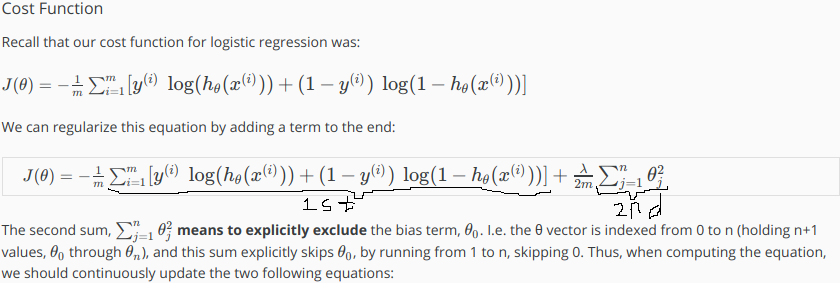

In [138]:
Image("Regularized_cost_function2.png", width=800, height=300)

In [139]:
# Regularized cost function intuition
# lambda is the regularization parameter, controls the trade-off between two goals

# The 1st goal is to fit the training set well
# The 2nd goal is to keep the parameter small, therefore keeping the hypothesis simple to avoid overfitting
# It's a bit difficult to see how shrinking the parameters can give a smoother line, 
# and gives a much better hypothesis for this data.

# Have to implement this algorithm yourself to see the effect

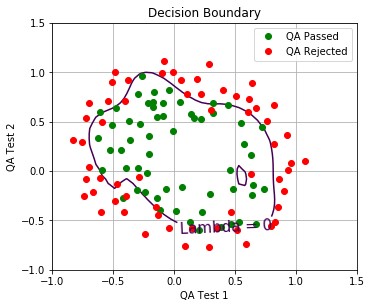

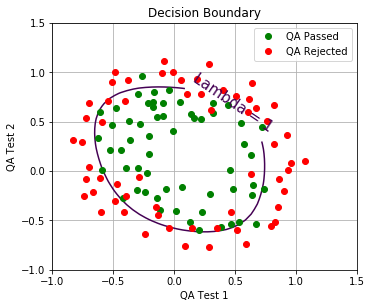

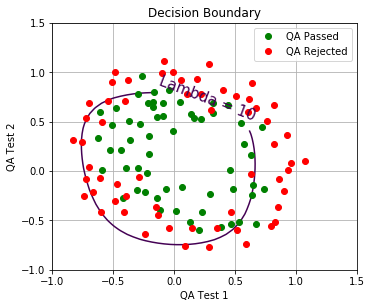

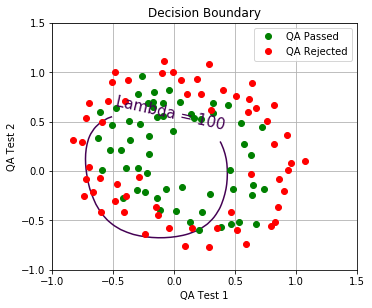

In [140]:
plt.figure(figsize=(12,10))
plt.subplot(221)
plot_data()
plot_boundary(theta, mappedX, y, 0.)

plt.figure(figsize=(12,10))
plt.subplot(221)
plot_data()
plot_boundary(theta, mappedX, y, 1.)

plt.figure(figsize=(12,10))
plt.subplot(221)
plot_data()
plot_boundary(theta, mappedX, y, 10.)

plt.figure(figsize=(12,10))
plt.subplot(221)
plot_data()
plot_boundary(theta, mappedX, y, 100.)

# Seems like a lambda of 1 fits the data the best